-Mahalakshmi M
- email: mahalakshmimageswarangamil.com


In [1]:
!pip install pyspark


In [3]:
# Import Libraries
# -------------------------
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StringType, IntegerType, FloatType
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
# Initialize Spark Session
spark = SparkSession.builder.appName("Retail Sales Pipeline").getOrCreate()

In [5]:
# Parameterize Time Period Selection
# -------------------------------------------
# Define weekly and monthly ranges dynamically
time_period = "Weekly"  # Change to "Monthly" as needed
today = date.today()

if time_period == "Weekly":
    start_date = today - timedelta(days=today.weekday(), weeks=1)
    end_date = start_date + timedelta(days=6)
else:
    first = today.replace(day=1)
    end_date = first - timedelta(days=1)
    start_date = first - timedelta(days=end_date.day)

print(f"Analyzing data from {start_date} to {end_date}")


Analyzing data from 2025-05-19 to 2025-05-25


In [7]:

# Load retail sales data into a Spark DataFrame
file_path = "superstore.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
print("Data Schema:")
df.printSchema()


Data Schema:
root
 |-- ID: integer (nullable = true)
 |-- Order_id: string (nullable = true)
 |-- Order_Date: string (nullable = true)
 |-- Ship _Date: date (nullable = true)
 |-- Ship_Mode: string (nullable = true)
 |-- Customer_id: string (nullable = true)
 |-- Customer_Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal_Code: integer (nullable = true)
 |-- Region: string (nullable = true)
 |-- Product_ ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub_Category: string (nullable = true)
 |-- Product_Name: string (nullable = true)
 |-- Sales: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- Discount: string (nullable = true)
 |-- Profit: double (nullable = true)
 |-- user_id: double (nullable = true)
 |-- state_id: double (nullable = true)
 |-- order_s: string (nullable = true)



In [8]:
# Display a sample of the data
df.show(5)

+---+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+-------+--------+-------+
| ID|      Order_id|Order_Date|Ship _Date|     Ship_Mode|Customer_id|  Customer_Name|  Segment|      Country|           City|     State|Postal_Code|Region|    Product_ ID|       Category|Sub_Category|        Product_Name|   Sales|Quantity|Discount|  Profit|user_id|state_id|order_s|
+---+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+-------+--------+-------+
|  1|CA-2023-152156|2023-11-08|2023-11-11|  Second Class|   CG-12520|    Claire Gute| Consumer|United States|      Henderson|  Kentucky|      42420| So

# **Data Transformation**

In [18]:
print("Original Order_Date sample values:")
df.select("Order_Date").distinct().show(10, truncate=False)

print("Order_Date after to_date conversion:")
data_cleaned.select("Order_Date").distinct().show(10, truncate=False)


Original Order_Date sample values:
+----------+
|Order_Date|
+----------+
|2024-09-15|
|2022-10-05|
|2023-05-18|
|2024-01-19|
|2024-08-20|
|2023-05-01|
|2023-01-21|
|2021-11-03|
|2024-07-14|
|2024-10-24|
+----------+
only showing top 10 rows

Order_Date after to_date conversion:
+----------+
|Order_Date|
+----------+
|2021-08-27|
|2024-09-18|
|2021-06-22|
|2022-03-28|
|2022-07-31|
|2023-07-15|
|2021-10-11|
|2021-01-27|
|2023-11-08|
|2024-08-27|
+----------+
only showing top 10 rows



In [19]:
print(f"Filtering data from {start_date} to {end_date}")


Filtering data from 2025-05-19 to 2025-05-25


In [20]:
from pyspark.sql.functions import min, max

date_bounds = data_cleaned.select(min("Order_Date").alias("min_date"), max("Order_Date").alias("max_date")).collect()[0]
print(f"Data date range: {date_bounds.min_date} to {date_bounds.max_date}")

start_date = str(date_bounds.min_date)
end_date = str(date_bounds.max_date)


Data date range: 2021-01-03 to 2024-12-30


In [22]:
#Filter your data with the date range
data_filtered = data_cleaned.filter(
    (col("Order_Date") >= lit(start_date)) & (col("Order_Date") <= lit(end_date))
)

print(f"Filtering data from {start_date} to {end_date}")
data_filtered.show(5)
print("Filtered data count:", data_filtered.count())


Filtering data from 2021-01-03 to 2024-12-30
+---+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+-------+--------+-------+
| ID|      Order_id|Order_Date|Ship _Date|     Ship_Mode|Customer_id|  Customer_Name|  Segment|      Country|           City|     State|Postal_Code|Region|    Product_ ID|       Category|Sub_Category|        Product_Name|   Sales|Quantity|Discount|  Profit|user_id|state_id|order_s|
+---+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+-------+--------+-------+
|  1|CA-2023-152156|2023-11-08|2023-11-11|  Second Class|   CG-12520|    Claire Gute| Consumer|United Stat

In [24]:
# Aggregate sales and profit by category

aggregated_data = (
    data_filtered
    .groupBy("Category")
    .agg(
        round(sum("Sales"), 2).alias("Total Sales"),
        round(sum("Profit"), 2).alias("Total Profit")
    )
    .orderBy(col("Total Sales").desc())
)

print("Aggregated Sales Data:")
aggregated_data.show()


Aggregated Sales Data:
+---------------+-----------+------------+
|       Category|Total Sales|Total Profit|
+---------------+-----------+------------+
|     Technology|  835900.06|    145388.3|
|      Furniture|  733046.86|    19686.43|
|Office Supplies|  703391.82|   120624.55|
+---------------+-----------+------------+



# **Data Quality Checks**

In [27]:
# Check for nulls in critical columns
null_counts = {col: data_cleaned.filter(data_cleaned[col].isNull()).count() for col in ["Sales", "Profit", "Order_Date"]}
print("Null Value Counts:", null_counts)

Null Value Counts: {'Sales': 300, 'Profit': 0, 'Order_Date': 1}


In [34]:
from pyspark.sql.functions import mean, min, col, to_date

# Calculate mean for Sales and Profit
mean_values = data_cleaned.select(
    mean("Sales").alias("mean_Sales"),
    mean("Profit").alias("mean_Profit")
).collect()[0]

mean_sales = mean_values["mean_Sales"]
mean_profit = mean_values["mean_Profit"]

# Fill nulls in Sales and Profit
data_filled = data_cleaned.fillna({
    "Sales": mean_sales,
    "Profit": mean_profit
})

# Get min Order_Date as string
min_order_date = data_cleaned.select(min("Order_Date")).collect()[0][0]
min_order_date_str = str(min_order_date)

# Convert Order_Date to string column to fill nulls
data_with_date_str = data_filled.withColumn("Order_Date_Str", col("Order_Date").cast("string"))

# Fill nulls in Order_Date_Str
data_filled_str = data_with_date_str.fillna({"Order_Date_Str": min_order_date_str})

# Convert back to date and drop temp column
data_filled_final = data_filled_str.withColumn("Order_Date", to_date(col("Order_Date_Str"), "yyyy-MM-dd")) \
                                  .drop("Order_Date_Str")

# Check null counts again
null_counts_after = {col_name: data_filled_final.filter(data_filled_final[col_name].isNull()).count() for col_name in ["Sales", "Profit", "Order_Date"]}
print("Null Value Counts after filling:", null_counts_after)


Null Value Counts after filling: {'Sales': 0, 'Profit': 0, 'Order_Date': 0}


In [35]:
# Check for duplicates
duplicate_count = data_cleaned.count() - data_cleaned.distinct().count()
print(f"Duplicate Records: {duplicate_count}")


Duplicate Records: 0


## **Visualization**

In [37]:
#Convert Spark DataFrame to Pandas for visualization
pandas_df = aggregated_data.toPandas()


<ipython-input-38-cd63947860e6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pandas_df, x="Total Sales", y="Category", palette="viridis")


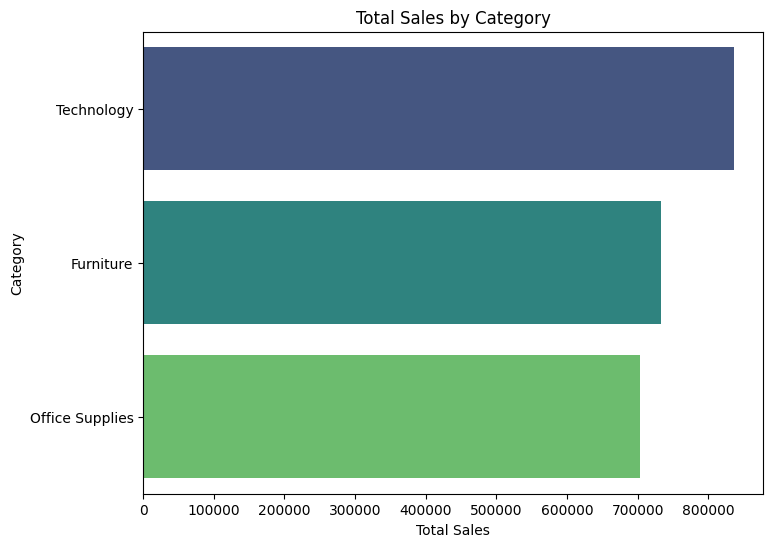

In [38]:
# Bar chart of total sales by category
plt.figure(figsize=(8, 6))
sns.barplot(data=pandas_df, x="Total Sales", y="Category", palette="viridis")
plt.title("Total Sales by Category")
plt.xlabel("Total Sales")
plt.ylabel("Category")
plt.show()

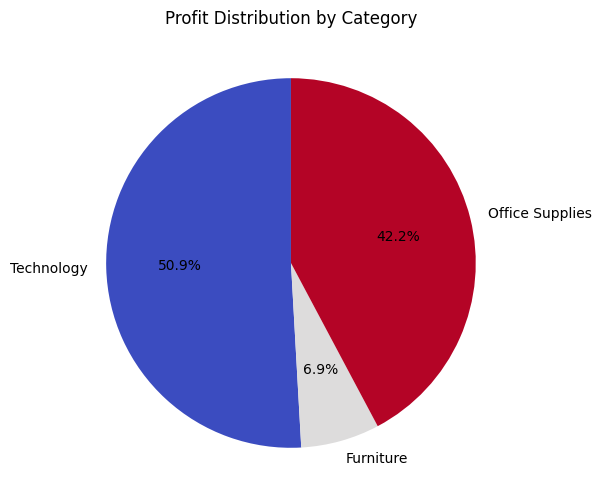

In [39]:
# Pie chart of profit distribution
plt.figure(figsize=(8, 6))
pandas_df.set_index("Category")["Total Profit"].plot.pie(autopct="%1.1f%%", startangle=90, cmap="coolwarm")
plt.title("Profit Distribution by Category")
plt.ylabel("")
plt.show()

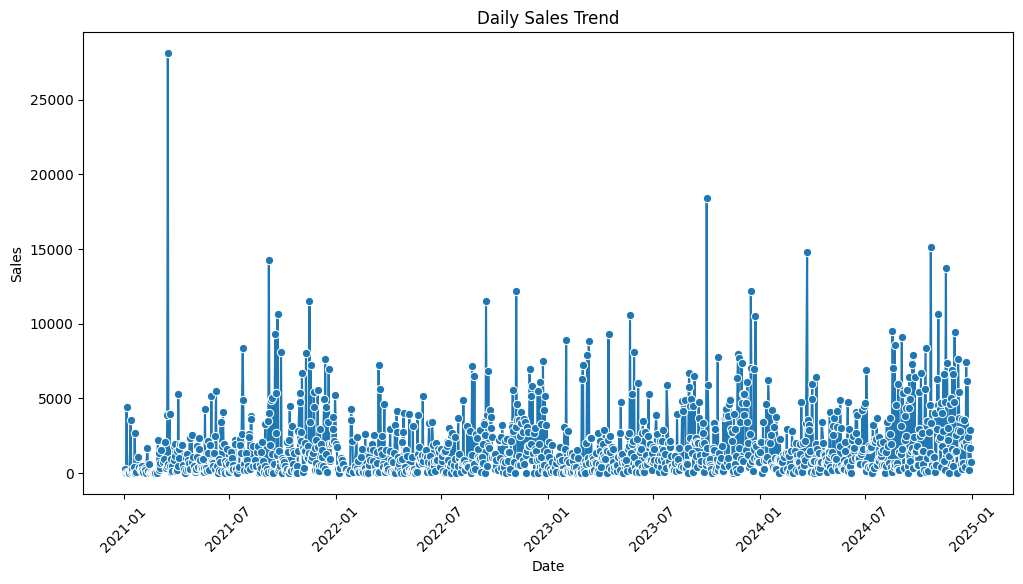

In [43]:
# Trend line for sales over time
sales_trend = (data_filtered
    .groupBy("Order_Date")
    .agg(sum("Sales").alias("Daily Sales"))
    .orderBy("Order_Date")
)
sales_trend_pd = sales_trend.toPandas()
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_trend_pd, x="Order_Date", y="Daily Sales", marker="o")
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.show()

# **Scalability Demonstration**

In [44]:
# Simulate a large dataset by duplicating rows
large_data = data_cleaned.unionAll(data_cleaned)
print(f"Original Row Count: {data_cleaned.count()}, Scaled Row Count: {large_data.count()}")


Original Row Count: 9994, Scaled Row Count: 19988


In [46]:
#Re-run aggregation on scaled dataset
aggregated_large_data = (large_data
    .groupBy("Category")
    .agg(
        round(sum("Sales"), 2).alias("Total Sales"),
        round(sum("Profit"), 2).alias("Total Profit")
    )
    .orderBy(col("Total Sales").desc())
)

print("Aggregated Data on Scaled Dataset:")
aggregated_large_data.show()


Aggregated Data on Scaled Dataset:
+---------------+-----------+------------+
|       Category|Total Sales|Total Profit|
+---------------+-----------+------------+
|     Technology| 1671800.13|   290776.59|
|      Furniture| 1466093.72|    39372.85|
|Office Supplies| 1407005.85|   241265.76|
+---------------+-----------+------------+



# **Recommendations**

In [47]:
recommendations = [
    "Focus on the top-performing category for sales to maximize revenue.",
    "Investigate categories with high sales but low profit margins for potential cost optimizations.",
    "Expand marketing efforts during peak sales periods identified in the trend analysis.",
    "Improve inventory management for categories showing consistent sales growth."
]

print("\nBusiness Recommendations:")
for rec in recommendations:
    print(f"- {rec}")


Business Recommendations:
- Focus on the top-performing category for sales to maximize revenue.
- Investigate categories with high sales but low profit margins for potential cost optimizations.
- Expand marketing efforts during peak sales periods identified in the trend analysis.
- Improve inventory management for categories showing consistent sales growth.
